#### Creating and analysing a GAN network

In [78]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
import keras
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers import Conv2D, MaxPool2D, Flatten
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.datasets import mnist, cifar10
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from keras import initializers
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC


import warnings
warnings.filterwarnings('ignore')

Setting Context for visualisations:

In [79]:
import seaborn as sns;
#setting theme for any data visualization neede
sns.set_theme(context='notebook',style='darkgrid',palette='deep',font_scale=1)

#### Playing with the hyper-parameters such as learning rate, batch size, optimizer, and layers to generate good quality images.

In [80]:
# Let Keras know that we are using tensorflow as our backend engine of our random noise vector.
os.environ["KERAS_BACKEND"] = "tensorflow"
# The dimension 
random_dim = 100
# To make sure that we can reproduce the experiment and get the same results
np.random.seed(10)

In [81]:
def load_minst_data():
    # load the data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # normalize our inputs to be in the range[-1, 1]
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

In [82]:
# You will use the Adam optimizer
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(2048))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(128))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [83]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [84]:
# Create a wall of generated MNIST images
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

--------------- Epoch 0 ---------------


100%|██████████| 468/468 [01:00<00:00,  7.71it/s]


--------------- Epoch 1 ---------------


100%|██████████| 468/468 [01:05<00:00,  7.14it/s]


--------------- Epoch 2 ---------------


100%|██████████| 468/468 [01:03<00:00,  7.34it/s]


--------------- Epoch 3 ---------------


100%|██████████| 468/468 [01:03<00:00,  7.40it/s]


--------------- Epoch 4 ---------------


100%|██████████| 468/468 [01:02<00:00,  7.46it/s]


--------------- Epoch 5 ---------------


100%|██████████| 468/468 [01:02<00:00,  7.54it/s]


--------------- Epoch 6 ---------------


100%|██████████| 468/468 [01:01<00:00,  7.55it/s]


--------------- Epoch 7 ---------------


100%|██████████| 468/468 [01:01<00:00,  7.58it/s]


--------------- Epoch 8 ---------------


100%|██████████| 468/468 [01:02<00:00,  7.51it/s]


--------------- Epoch 9 ---------------


100%|██████████| 468/468 [01:02<00:00,  7.53it/s]


--------------- Epoch 10 ---------------


100%|██████████| 468/468 [01:03<00:00,  7.34it/s]


--------------- Epoch 11 ---------------


100%|██████████| 468/468 [01:02<00:00,  7.55it/s]


--------------- Epoch 12 ---------------


100%|██████████| 468/468 [01:02<00:00,  7.52it/s]


--------------- Epoch 13 ---------------


100%|██████████| 468/468 [01:01<00:00,  7.57it/s]


--------------- Epoch 14 ---------------


100%|██████████| 468/468 [01:02<00:00,  7.50it/s]


--------------- Epoch 15 ---------------


100%|██████████| 468/468 [01:02<00:00,  7.52it/s]


--------------- Epoch 16 ---------------


100%|██████████| 468/468 [01:01<00:00,  7.60it/s]


--------------- Epoch 17 ---------------


100%|██████████| 468/468 [01:02<00:00,  7.46it/s]


--------------- Epoch 18 ---------------


100%|██████████| 468/468 [01:03<00:00,  7.33it/s]


--------------- Epoch 19 ---------------


100%|██████████| 468/468 [01:02<00:00,  7.49it/s]


--------------- Epoch 20 ---------------


100%|██████████| 468/468 [01:02<00:00,  7.52it/s]


--------------- Epoch 21 ---------------


100%|██████████| 468/468 [01:02<00:00,  7.53it/s]


--------------- Epoch 22 ---------------


100%|██████████| 468/468 [01:04<00:00,  7.30it/s]


--------------- Epoch 23 ---------------


100%|██████████| 468/468 [01:03<00:00,  7.34it/s]


--------------- Epoch 24 ---------------


100%|██████████| 468/468 [01:04<00:00,  7.26it/s]


--------------- Epoch 25 ---------------


100%|██████████| 468/468 [01:02<00:00,  7.46it/s]


--------------- Epoch 26 ---------------


100%|██████████| 468/468 [01:01<00:00,  7.59it/s]


--------------- Epoch 27 ---------------


100%|██████████| 468/468 [01:02<00:00,  7.49it/s]


--------------- Epoch 28 ---------------


100%|██████████| 468/468 [01:04<00:00,  7.28it/s]


--------------- Epoch 29 ---------------


100%|██████████| 468/468 [01:03<00:00,  7.37it/s]


--------------- Epoch 30 ---------------


100%|██████████| 468/468 [01:04<00:00,  7.29it/s]


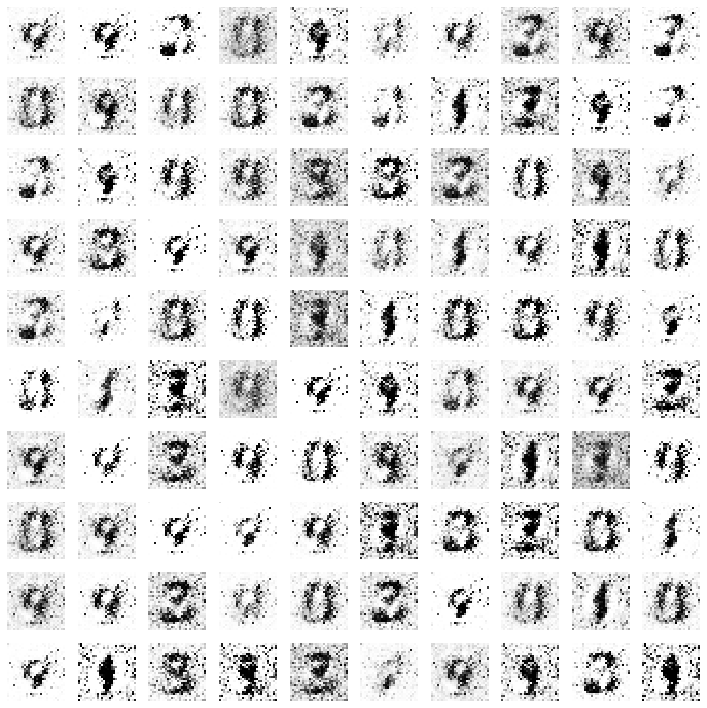

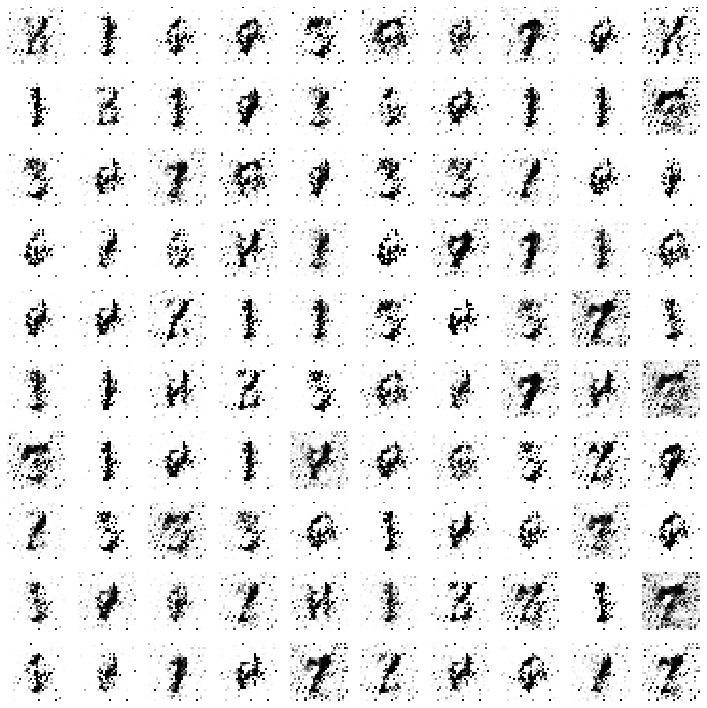

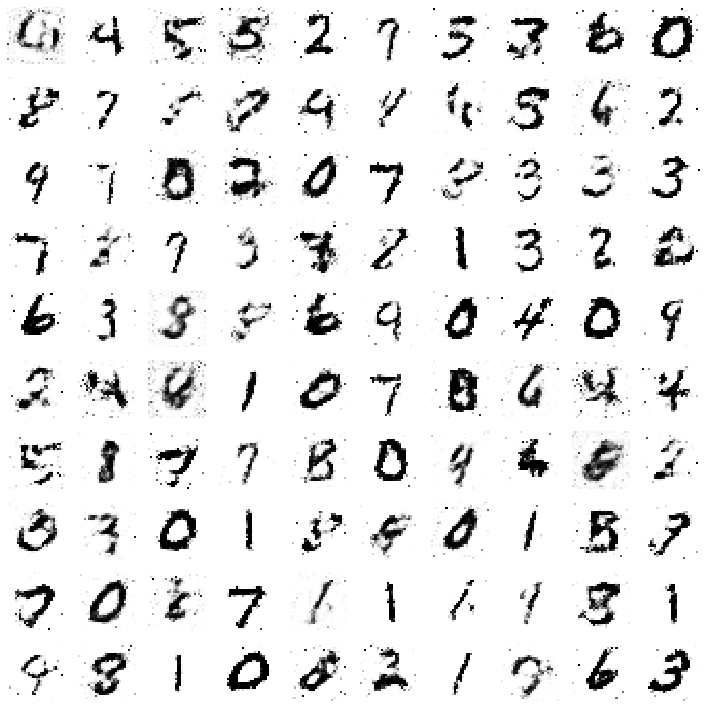

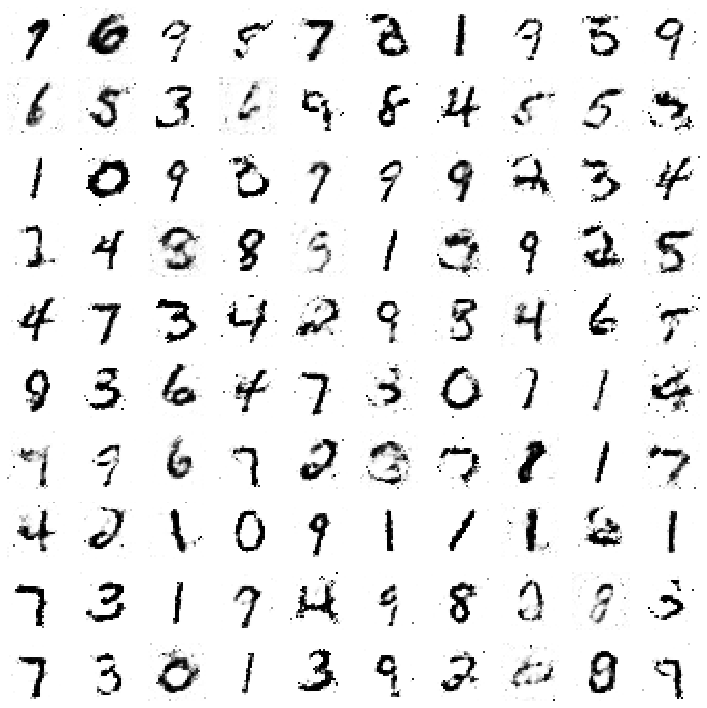

In [85]:
import math
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] / batch_size

    # Build our GAN netowrk
    adam = get_optimizer()
    SGD = get_optimizer1() #changing a hyperparameter for optimizer (1)
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(math.floor(batch_count))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if e == 1 or e % 20 == 0 or e == 30:
            plot_generated_images(e, generator)

if __name__ == '__main__':
    train(30, 128)

#### Calculating the image quality generated in each variation you have applied in your code and see what impact in terms of image quality you can observe.

In [66]:
!pip3 install image-quality

  Created wheel for libsvm: filename=libsvm-3.23.0.4-py3-none-any.whl size=150376 sha256=a364fb5fe87c5fd255644bc033e86ce84549f0a9d6caaeda6f7fafd2a8421358
  Stored in directory: c:\users\rajit\appdata\local\pip\cache\wheels\c1\ce\25\0d50035499973fcbcc407fcb897d53e47b6eb4601308789aa6
Successfully built libsvm


In [72]:
import imquality.brisque as brisque
import PIL.Image as img

In [86]:
print('Calculating image quality scores for 30 epochs with an extra hidden layer in both generator and determinator')
image11 = img.open('gan_generated_image_epoch_0.png')
image12 = img.open('gan_generated_image_epoch_1.png')
image13 = img.open('gan_generated_image_epoch_20.png')
image14 = img.open('gan_generated_image_epoch_30.png')
qs11 = brisque.score(image11)
qs12 = brisque.score(image12)
qs13 = brisque.score(image13)
qs14 = brisque.score(image14)
print(f'Image score for 0th epoch {qs11}')
print(f'Image score for 1th epoch {qs12}')
print(f'Image score for 20th epoch {qs13}')
print(f'Image score for 30th epoch {qs14}')

Calculating image quality scores for 30 epochs with an extra hidden layer in both generator and determinator
Image score for 0th epoch 58.12332879121445
Image score for 1th epoch 107.94298130637216
Image score for 20th epoch 89.64494459779766
Image score for 30th epoch 86.96566815599132


In [87]:
print('Calculating image quality scores for 20 epochs with no extra hidden layer in both generator and determinator')
image21 = img.open('Assignment5_images/gan_generated_image_epoch_0_20.png')
image22 = img.open('Assignment5_images/gan_generated_image_epoch_1_20.png')
image23 = img.open('Assignment5_images/gan_generated_image_epoch_20_20.png')
qs21 = brisque.score(image21)
qs22 = brisque.score(image22)
qs23 = brisque.score(image23)
print(f'Image score for 0th epoch {qs21}')
print(f'Image score for 1th epoch {qs22}')
print(f'Image score for 20th epoch {qs23}')

Calculating image quality scores for 20 epochs with no extra hidden layer in both generator and determinator
Image score for 0th epoch 40.77069013072182
Image score for 1th epoch 86.23149967098468
Image score for 20th epoch 95.14617245814932
